# Tutorial 4: Advanced Patterns - E-I Networks and Kernel-Based Connectivity

This tutorial explores biologically-inspired connectivity patterns including excitatory-inhibitory networks and kernel-based receptive fields.

## Overview

We'll cover:
- **Excitatory-Inhibitory Networks**: Implementing Dale's principle with separate E and I populations
- **Kernel-Based Connectivity**: Creating receptive field patterns using spatial kernels
- **Combining Patterns**: Building complex networks from multiple connectivity patterns

In [1]:
import brainunit as u
import matplotlib.pyplot as plt
import numpy as np

import braintools.conn as conn
import braintools.visualize as vis

## 1. Excitatory-Inhibitory Networks

### 1.1 Dale's Principle

**Dale's principle** states that a neuron releases the same neurotransmitter(s) at all of its synapses. This means neurons are either excitatory or inhibitory, never both.

In cortical circuits:
- ~80% of neurons are **excitatory** (glutamatergic)
- ~20% of neurons are **inhibitory** (GABAergic)
- Excitatory connections have positive weights
- Inhibitory connections have negative weights
- The E-I balance is critical for stable network dynamics

### 1.2 Creating a Basic E-I Network

In [2]:
# Create E-I network with 80% excitatory neurons
n_neurons = 500

ei_net = conn.ExcitatoryInhibitory(
    exc_ratio=0.8,  # 80% excitatory
    exc_prob=0.1,  # Excitatory connection probability
    inh_prob=0.2,  # Inhibitory connection probability (higher)
    exc_weight=1.0 * u.nS,  # Positive excitatory weights
    inh_weight=-0.8 * u.nS,  # Negative inhibitory weights
    seed=42
)

result = ei_net(pre_size=n_neurons, post_size=n_neurons)

print(f"Total connections: {len(result.pre_indices)}")
print(f"Excitatory neurons: {result.metadata['n_excitatory']}")
print(f"Inhibitory neurons: {result.metadata['n_inhibitory']}")

Total connections: 30028
Excitatory neurons: 400
Inhibitory neurons: 100


### 1.3 Visualizing E-I Connectivity Structure

Let's visualize the connectivity matrix showing the four connection types:
- **E→E**: Excitatory to Excitatory
- **E→I**: Excitatory to Inhibitory
- **I→E**: Inhibitory to Excitatory
- **I→I**: Inhibitory to Inhibitory

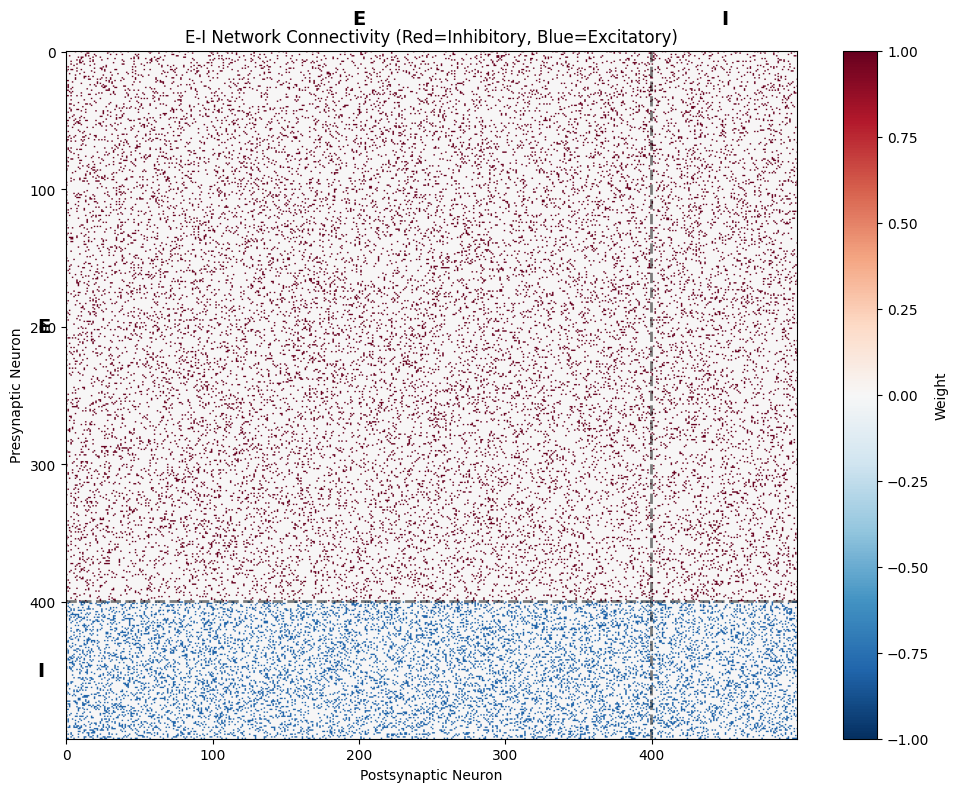

In [3]:
# Create connectivity matrix
conn_mat = np.zeros((n_neurons, n_neurons))
weights_vals = u.Quantity(result.weights).mantissa
conn_mat[result.pre_indices, result.post_indices] = weights_vals

# Visualize with center_zero to highlight positive/negative weights
fig, ax = plt.subplots(figsize=(10, 8))
vis.connectivity_matrix(
    conn_mat,
    cmap='RdBu_r',
    center_zero=True,
    show_colorbar=True,
    ax=ax,
    title='E-I Network Connectivity (Red=Inhibitory, Blue=Excitatory)',
    xlabel='Postsynaptic Neuron',
    ylabel='Presynaptic Neuron'
)

# Add lines to separate E and I populations
n_exc = result.metadata['n_excitatory']
ax.axhline(y=n_exc - 0.5, color='black', linewidth=2, linestyle='--', alpha=0.5)
ax.axvline(x=n_exc - 0.5, color='black', linewidth=2, linestyle='--', alpha=0.5)
ax.text(n_exc / 2, -20, 'E', ha='center', fontsize=14, fontweight='bold')
ax.text(n_exc + (n_neurons - n_exc) / 2, -20, 'I', ha='center', fontsize=14, fontweight='bold')
ax.text(-20, n_exc / 2, 'E', va='center', fontsize=14, fontweight='bold')
ax.text(-20, n_exc + (n_neurons - n_exc) / 2, 'I', va='center', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

### 1.4 Analyzing E-I Connection Statistics

Let's analyze the degree distributions separately for excitatory and inhibitory neurons.

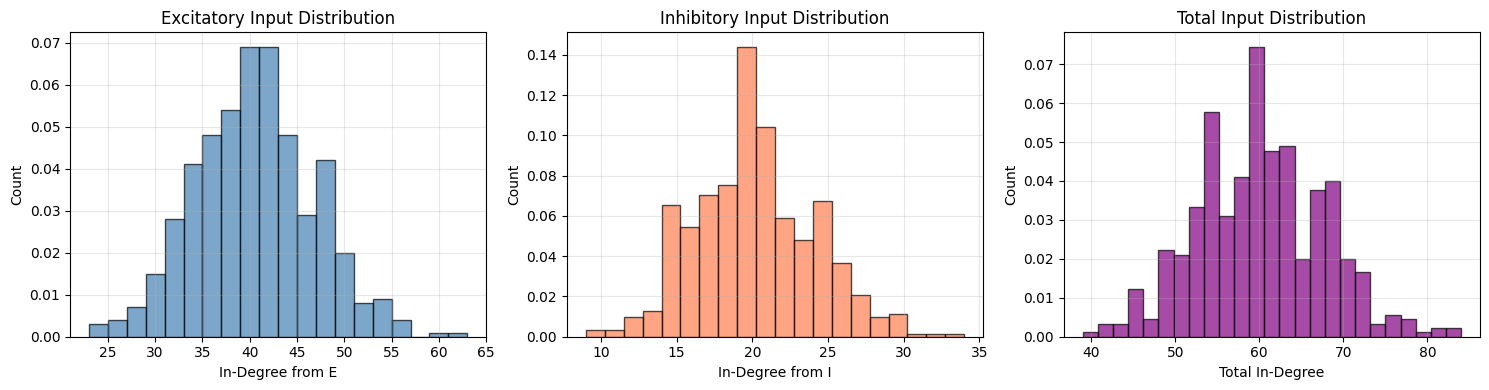

In [5]:
# Separate excitatory and inhibitory connections
n_exc = result.metadata['n_excitatory']
exc_mask = result.pre_indices < n_exc
inh_mask = result.pre_indices >= n_exc

# Calculate in-degrees from E and I separately
in_degree_from_E = np.bincount(result.post_indices[exc_mask], minlength=n_neurons)
in_degree_from_I = np.bincount(result.post_indices[inh_mask], minlength=n_neurons)
in_degree_total = np.bincount(result.post_indices, minlength=n_neurons)

# Visualize degree distributions
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

vis.distribution_plot(
    in_degree_from_E,
    bins=20,
    alpha=0.7,
    colors=['steelblue'],
    edgecolor='black',
    ax=axes[0],
    xlabel='In-Degree from E',
    ylabel='Count',
    title='Excitatory Input Distribution'
)

vis.distribution_plot(
    in_degree_from_I,
    bins=20,
    alpha=0.7,
    colors=['coral'],
    edgecolor='black',
    ax=axes[1],
    xlabel='In-Degree from I',
    ylabel='Count',
    title='Inhibitory Input Distribution'
)

vis.distribution_plot(
    in_degree_total,
    bins=25,
    alpha=0.7,
    colors=['purple'],
    edgecolor='black',
    ax=axes[2],
    xlabel='Total In-Degree',
    ylabel='Count',
    title='Total Input Distribution'
)

plt.tight_layout()
plt.show()

### 1.5 Weight Distribution Analysis

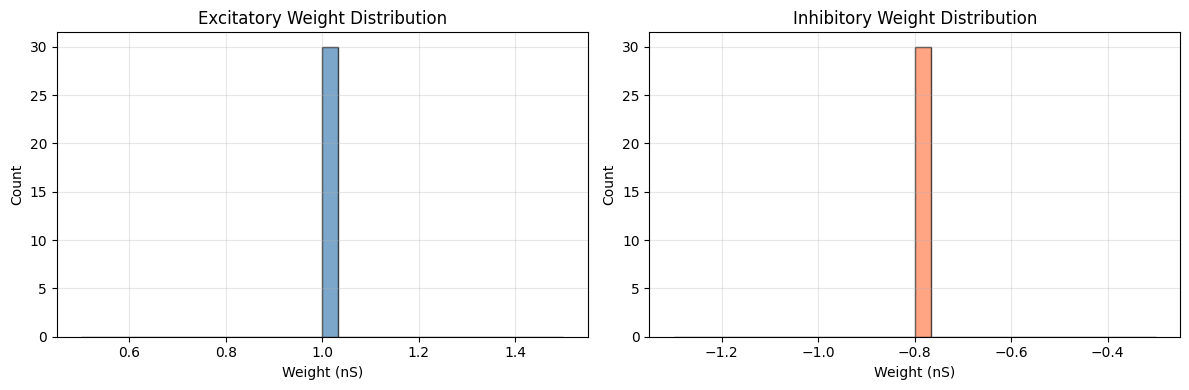

E/I weight ratio (magnitude): 1.25


In [6]:
# Separate excitatory and inhibitory weights
exc_weights = weights_vals[exc_mask]
inh_weights = weights_vals[inh_mask]

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

vis.distribution_plot(
    exc_weights,
    bins=30,
    alpha=0.7,
    colors=['steelblue'],
    edgecolor='black',
    ax=axes[0],
    xlabel='Weight (nS)',
    ylabel='Count',
    title='Excitatory Weight Distribution'
)

vis.distribution_plot(
    inh_weights,
    bins=30,
    alpha=0.7,
    colors=['coral'],
    edgecolor='black',
    ax=axes[1],
    xlabel='Weight (nS)',
    ylabel='Count',
    title='Inhibitory Weight Distribution'
)

plt.tight_layout()
plt.show()

print(f"E/I weight ratio (magnitude): {np.abs(np.mean(exc_weights) / np.mean(inh_weights)):.2f}")

## 2. Kernel-Based Connectivity

Kernel-based connectivity creates connections weighted by spatial functions, mimicking receptive field structures found in sensory systems.

### 2.1 Gaussian Kernel

Gaussian kernels create smooth, radially symmetric receptive fields. Connections closer to the center have stronger weights.

In [7]:
# Create 2D grid of neurons
grid_size = 20
n_neurons_2d = grid_size * grid_size

# Create grid positions
x = np.linspace(0, 1000, grid_size)
y = np.linspace(0, 1000, grid_size)
xx, yy = np.meshgrid(x, y)
positions = np.stack([xx.flatten(), yy.flatten()], axis=1) * u.um

# Create Gaussian kernel connectivity
gaussian = conn.GaussianKernel(
    sigma=100 * u.um,
    max_distance=300 * u.um,
    normalize=True,
    weight=5.0 * u.nS,
    seed=42
)

result_gaussian = gaussian(
    pre_size=n_neurons_2d,
    post_size=n_neurons_2d,
    pre_positions=positions,
    post_positions=positions
)

print(f"Gaussian kernel connections: {len(result_gaussian.pre_indices)}")
print(f"Average connections per neuron: {len(result_gaussian.pre_indices) / n_neurons_2d:.1f}")

Gaussian kernel connections: 20096
Average connections per neuron: 50.2


### 2.2 Visualizing Gaussian Connectivity

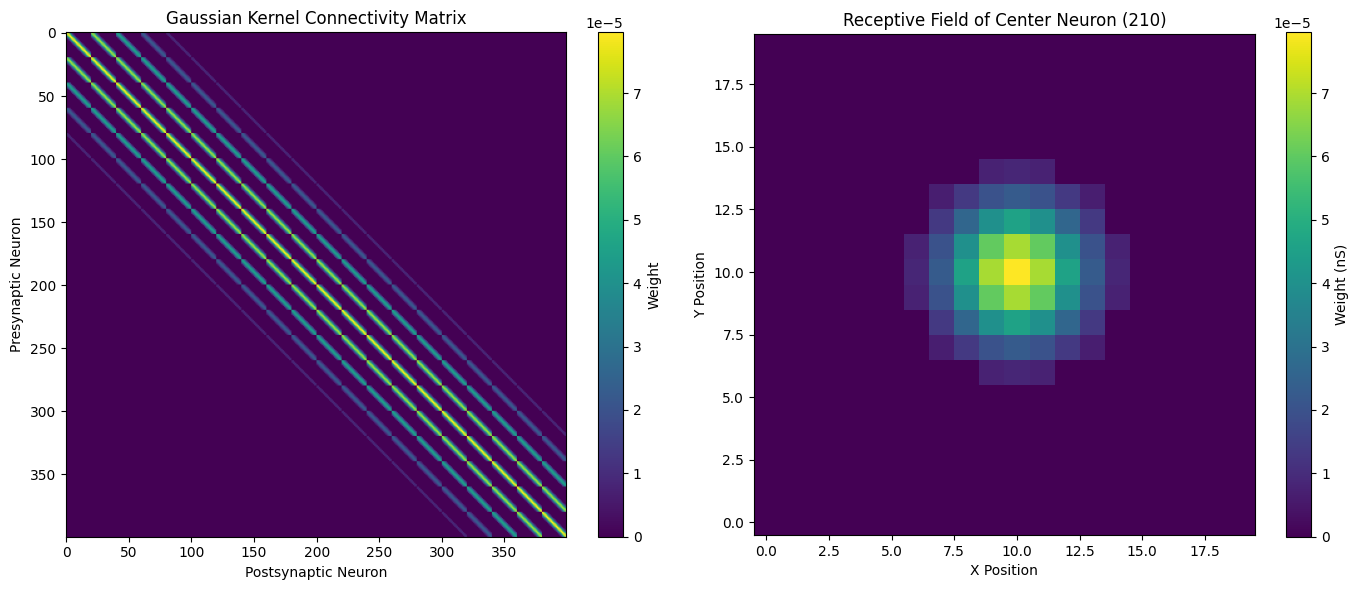

In [8]:
# Create connectivity matrix
conn_mat_gaussian = np.zeros((n_neurons_2d, n_neurons_2d))
weights_gaussian = u.Quantity(result_gaussian.weights).mantissa
conn_mat_gaussian[result_gaussian.pre_indices, result_gaussian.post_indices] = weights_gaussian

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Full connectivity matrix
vis.connectivity_matrix(
    conn_mat_gaussian,
    cmap='viridis',
    center_zero=False,
    show_colorbar=True,
    ax=axes[0],
    title='Gaussian Kernel Connectivity Matrix',
    xlabel='Postsynaptic Neuron',
    ylabel='Presynaptic Neuron'
)

# Receptive field of a single neuron (center neuron)
center_neuron = n_neurons_2d // 2 + grid_size // 2
receptive_field = conn_mat_gaussian[:, center_neuron].reshape(grid_size, grid_size)

im = axes[1].imshow(receptive_field, cmap='viridis', origin='lower')
axes[1].set_title(f'Receptive Field of Center Neuron ({center_neuron})')
axes[1].set_xlabel('X Position')
axes[1].set_ylabel('Y Position')
plt.colorbar(im, ax=axes[1], label='Weight (nS)')

plt.tight_layout()
plt.show()

### 2.3 Weight Distribution for Gaussian Kernel

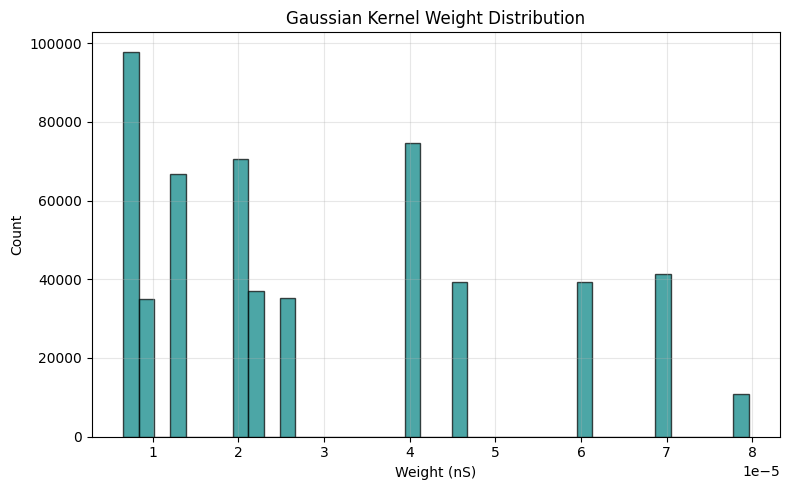

In [10]:
# Analyze Gaussian weight distribution
fig, ax = plt.subplots(figsize=(8, 5))

vis.distribution_plot(
    weights_gaussian,
    bins=40,
    alpha=0.7,
    colors=['teal'],
    edgecolor='black',
    ax=ax,
    xlabel='Weight (nS)',
    ylabel='Count',
    title='Gaussian Kernel Weight Distribution'
)

plt.tight_layout()
plt.show()

## 3. Gabor Kernel for Orientation Selectivity

Gabor kernels combine Gaussian envelopes with sinusoidal gratings, creating orientation-selective receptive fields similar to V1 simple cells.

In [11]:
# Create Gabor kernel with 45-degree orientation
gabor = conn.GaborKernel(
    sigma=80 * u.um,
    frequency=0.015,  # Cycles per micrometer
    theta=np.pi / 4,  # 45 degrees
    phase=0.0,
    max_distance=240 * u.um,
    weight=2.0 * u.nS,
    seed=42
)

result_gabor = gabor(
    pre_size=n_neurons_2d,
    post_size=n_neurons_2d,
    pre_positions=positions,
    post_positions=positions
)

print(f"Gabor kernel connections: {len(result_gabor.pre_indices)}")
print(f"Average connections per neuron: {len(result_gabor.pre_indices) / n_neurons_2d:.1f}")

Gabor kernel connections: 22400
Average connections per neuron: 56.0


### 3.1 Visualizing Gabor Receptive Fields

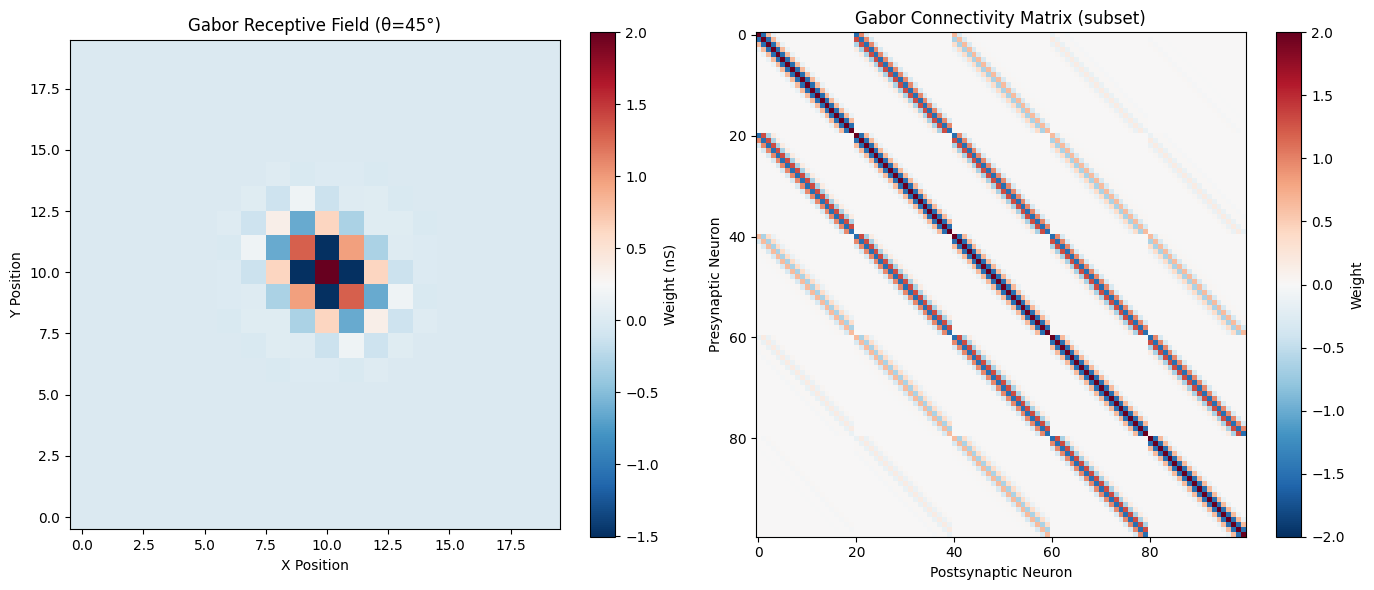

In [12]:
# Create connectivity matrix
conn_mat_gabor = np.zeros((n_neurons_2d, n_neurons_2d))
weights_gabor = u.Quantity(result_gabor.weights).mantissa
conn_mat_gabor[result_gabor.pre_indices, result_gabor.post_indices] = weights_gabor

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Receptive field of center neuron
center_neuron = n_neurons_2d // 2 + grid_size // 2
receptive_field_gabor = conn_mat_gabor[:, center_neuron].reshape(grid_size, grid_size)

im0 = axes[0].imshow(receptive_field_gabor, cmap='RdBu_r', origin='lower')
axes[0].set_title(f'Gabor Receptive Field (θ=45°)')
axes[0].set_xlabel('X Position')
axes[0].set_ylabel('Y Position')
plt.colorbar(im0, ax=axes[0], label='Weight (nS)')

# Show a portion of the connectivity matrix
vis.connectivity_matrix(
    conn_mat_gabor[:100, :100],
    cmap='RdBu_r',
    center_zero=True,
    show_colorbar=True,
    ax=axes[1],
    title='Gabor Connectivity Matrix (subset)',
    xlabel='Postsynaptic Neuron',
    ylabel='Presynaptic Neuron'
)

plt.tight_layout()
plt.show()

### 3.2 Comparing Multiple Orientations

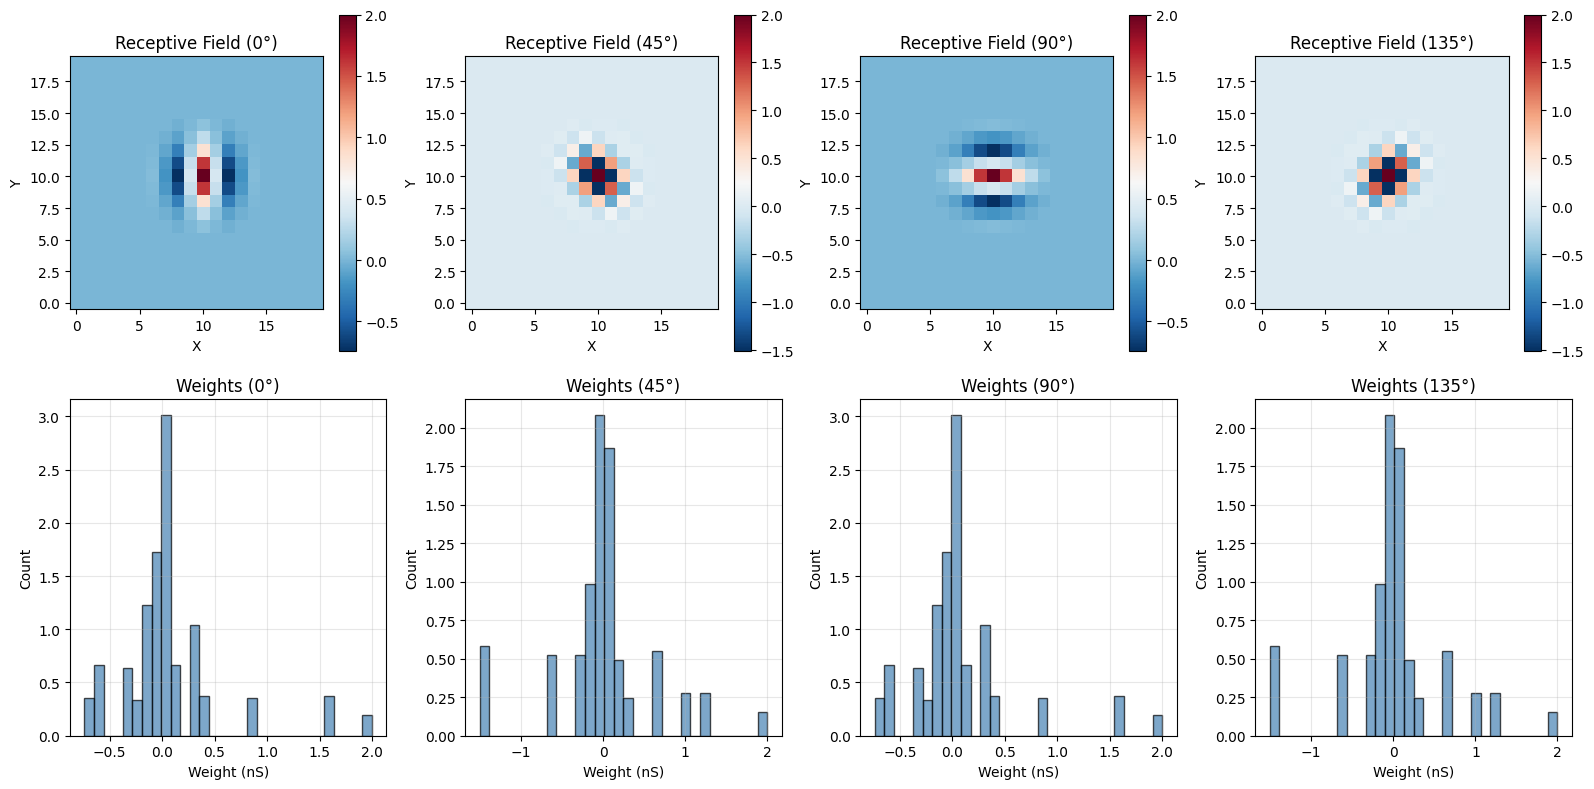

In [13]:
# Create Gabor kernels at different orientations
orientations = [0, np.pi / 4, np.pi / 2, 3 * np.pi / 4]
orientation_names = ['0°', '45°', '90°', '135°']

fig, axes = plt.subplots(2, 4, figsize=(16, 8))

for idx, (theta, name) in enumerate(zip(orientations, orientation_names)):
    gabor_oriented = conn.GaborKernel(
        sigma=80 * u.um,
        frequency=0.015,
        theta=theta,
        phase=0.0,
        max_distance=240 * u.um,
        weight=2.0 * u.nS,
        seed=42
    )

    result = gabor_oriented(
        pre_size=n_neurons_2d,
        post_size=n_neurons_2d,
        pre_positions=positions,
        post_positions=positions
    )

    conn_mat = np.zeros((n_neurons_2d, n_neurons_2d))
    weights = u.Quantity(result.weights).mantissa
    conn_mat[result.pre_indices, result.post_indices] = weights

    # Show receptive field
    rf = conn_mat[:, center_neuron].reshape(grid_size, grid_size)
    im = axes[0, idx].imshow(rf, cmap='RdBu_r', origin='lower')
    axes[0, idx].set_title(f'Receptive Field ({name})')
    axes[0, idx].set_xlabel('X')
    axes[0, idx].set_ylabel('Y')
    plt.colorbar(im, ax=axes[0, idx])

    # Show weight distribution
    vis.distribution_plot(
        weights,
        bins=30,
        alpha=0.7,
        colors=['steelblue'],
        edgecolor='black',
        ax=axes[1, idx],
        xlabel='Weight (nS)',
        ylabel='Count',
        title=f'Weights ({name})'
    )

plt.tight_layout()
plt.show()

## 4. Difference of Gaussians (DoG) Kernel

DoG kernels create center-surround receptive fields found in retinal ganglion cells and LGN neurons. The center and surround have opposite signs, creating edge detection properties.

In [14]:
# Create DoG kernel with center-surround structure
dog = conn.DoGKernel(
    sigma_center=50 * u.um,
    sigma_surround=100 * u.um,
    amplitude_center=1.0,
    amplitude_surround=0.8,
    max_distance=300 * u.um,
    weight=3.0 * u.nS,
    seed=42
)

result_dog = dog(
    pre_size=n_neurons_2d,
    post_size=n_neurons_2d,
    pre_positions=positions,
    post_positions=positions
)

print(f"DoG kernel connections: {len(result_dog.pre_indices)}")
print(f"Average connections per neuron: {len(result_dog.pre_indices) / n_neurons_2d:.1f}")

DoG kernel connections: 31240
Average connections per neuron: 78.1


### 4.1 Visualizing Center-Surround Structure

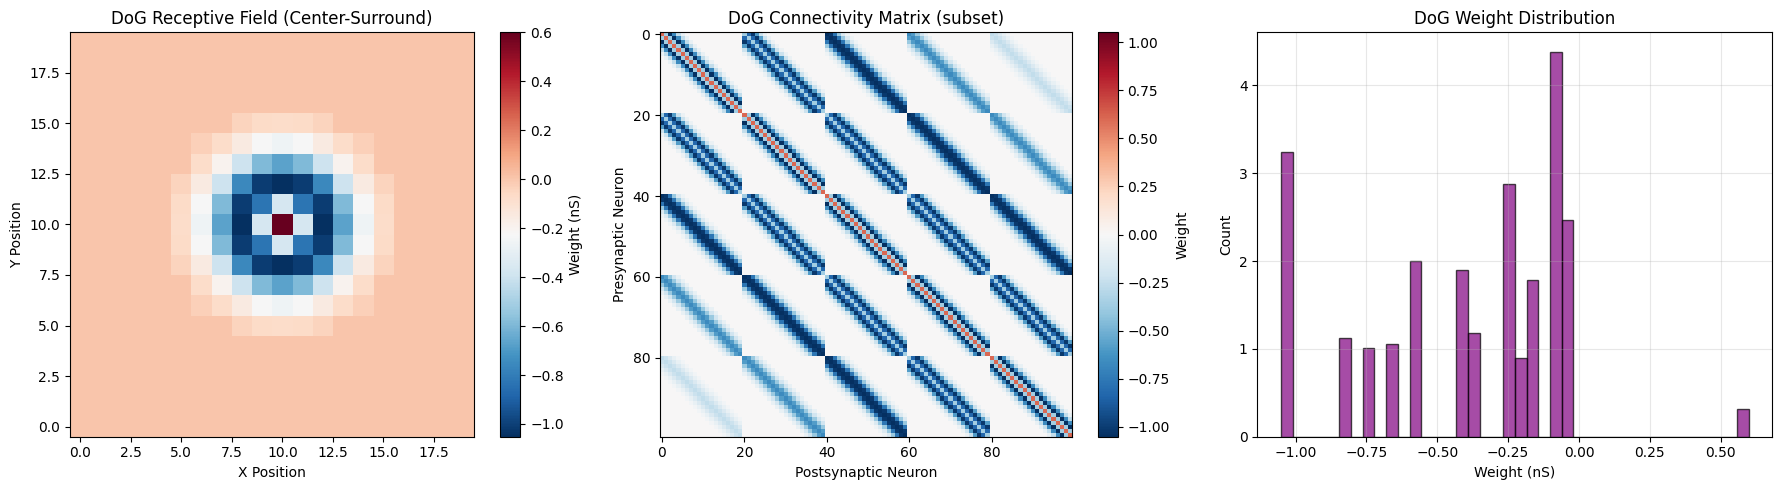

In [16]:
# Create connectivity matrix
conn_mat_dog = np.zeros((n_neurons_2d, n_neurons_2d))
weights_dog = u.Quantity(result_dog.weights).mantissa
conn_mat_dog[result_dog.pre_indices, result_dog.post_indices] = weights_dog

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Receptive field showing center-surround
center_neuron = n_neurons_2d // 2 + grid_size // 2
receptive_field_dog = conn_mat_dog[:, center_neuron].reshape(grid_size, grid_size)

im0 = axes[0].imshow(receptive_field_dog, cmap='RdBu_r', origin='lower')
axes[0].set_title('DoG Receptive Field (Center-Surround)')
axes[0].set_xlabel('X Position')
axes[0].set_ylabel('Y Position')
plt.colorbar(im0, ax=axes[0], label='Weight (nS)')

# Connectivity matrix
vis.connectivity_matrix(
    conn_mat_dog[:100, :100],
    cmap='RdBu_r',
    center_zero=True,
    show_colorbar=True,
    ax=axes[1],
    title='DoG Connectivity Matrix (subset)',
    xlabel='Postsynaptic Neuron',
    ylabel='Presynaptic Neuron'
)

# Weight distribution
vis.distribution_plot(
    weights_dog,
    bins=40,
    alpha=0.7,
    colors=['purple'],
    edgecolor='black',
    ax=axes[2],
    xlabel='Weight (nS)',
    ylabel='Count',
    title='DoG Weight Distribution'
)

plt.tight_layout()
plt.show()

### 4.2 Mexican Hat (Laplacian of Gaussian)

The Mexican Hat kernel is a special case of DoG that approximates the Laplacian of Gaussian, creating strong lateral inhibition.

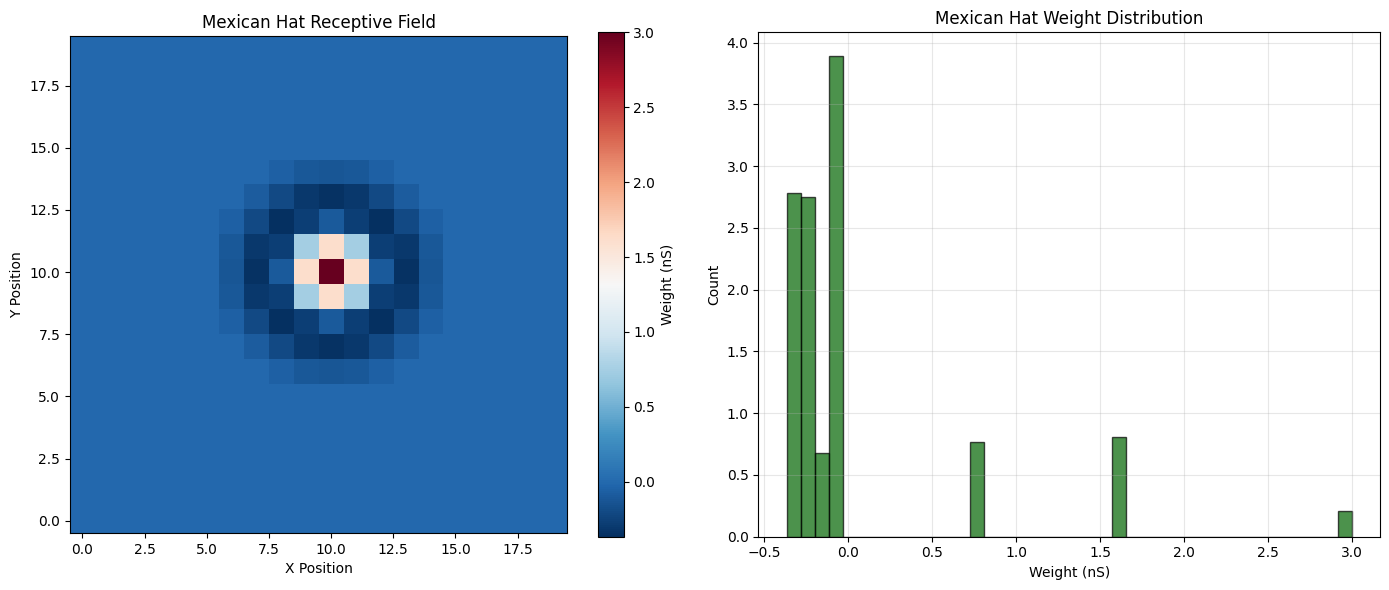

In [17]:
# Create Mexican Hat kernel
mexican = conn.MexicanHat(
    sigma=60 * u.um,
    max_distance=240 * u.um,
    weight=3.0 * u.nS,
    seed=42
)

result_mexican = mexican(
    pre_size=n_neurons_2d,
    post_size=n_neurons_2d,
    pre_positions=positions,
    post_positions=positions
)

# Visualize
conn_mat_mexican = np.zeros((n_neurons_2d, n_neurons_2d))
weights_mexican = u.Quantity(result_mexican.weights).mantissa
conn_mat_mexican[result_mexican.pre_indices, result_mexican.post_indices] = weights_mexican

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Receptive field
rf_mexican = conn_mat_mexican[:, center_neuron].reshape(grid_size, grid_size)
im0 = axes[0].imshow(rf_mexican, cmap='RdBu_r', origin='lower')
axes[0].set_title('Mexican Hat Receptive Field')
axes[0].set_xlabel('X Position')
axes[0].set_ylabel('Y Position')
plt.colorbar(im0, ax=axes[0], label='Weight (nS)')

# Weight distribution
vis.distribution_plot(
    weights_mexican,
    bins=40,
    alpha=0.7,
    colors=['darkgreen'],
    edgecolor='black',
    ax=axes[1],
    xlabel='Weight (nS)',
    ylabel='Count',
    title='Mexican Hat Weight Distribution'
)

plt.tight_layout()
plt.show()

## 5. Custom Kernels

You can create arbitrary kernel functions for specialized connectivity patterns.

In [18]:
# Define a custom spiral kernel
def spiral_kernel(x, y):
    """Custom spiral kernel function."""
    r = np.sqrt(x ** 2 + y ** 2)
    theta = np.arctan2(y, x)
    # Spiral pattern: decays with distance, modulated by angle
    return np.exp(-r / 100) * np.cos(r / 30 + 3 * theta)


# Create custom kernel connectivity
custom = conn.CustomKernel(
    kernel_func=spiral_kernel,
    kernel_size=400 * u.um,
    threshold=0.1,
    weight=2.0 * u.nS,
    seed=42
)

result_custom = custom(
    pre_size=n_neurons_2d,
    post_size=n_neurons_2d,
    pre_positions=positions,
    post_positions=positions
)

print(f"Custom kernel connections: {len(result_custom.pre_indices)}")

Custom kernel connections: 11990


### 5.1 Visualizing Custom Kernel

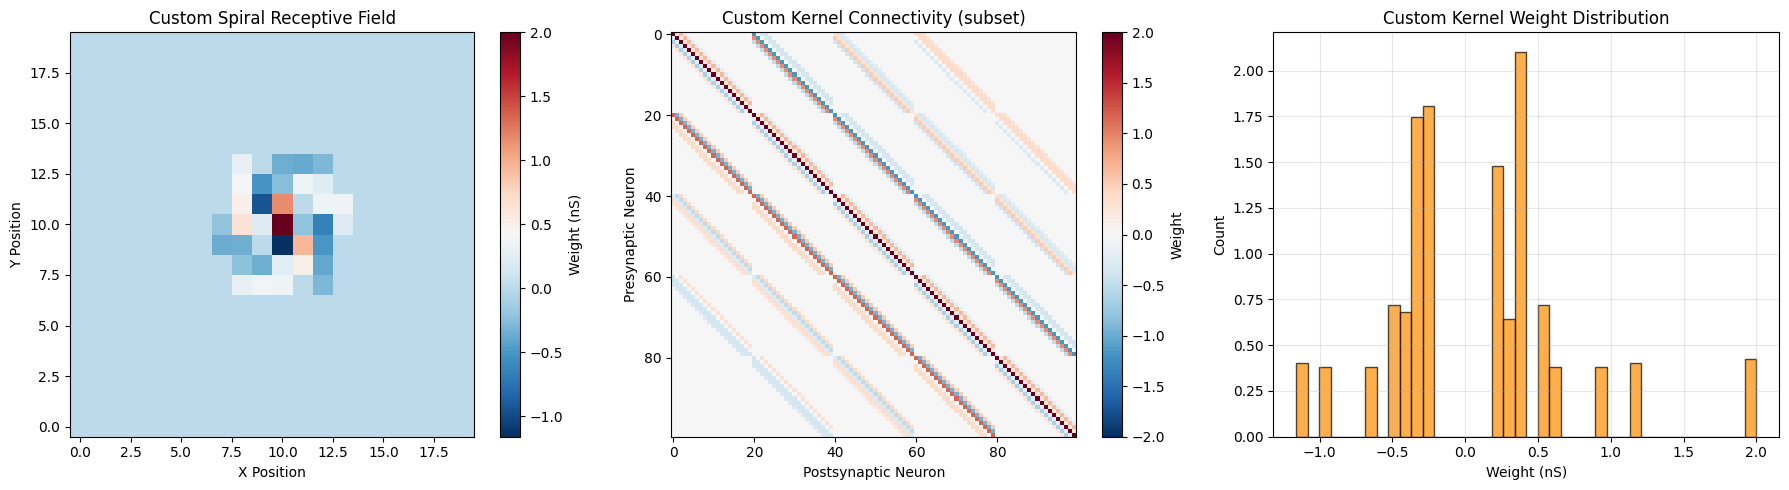

In [19]:
# Create connectivity matrix
conn_mat_custom = np.zeros((n_neurons_2d, n_neurons_2d))
weights_custom = u.Quantity(result_custom.weights).mantissa
conn_mat_custom[result_custom.pre_indices, result_custom.post_indices] = weights_custom

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Receptive field
rf_custom = conn_mat_custom[:, center_neuron].reshape(grid_size, grid_size)
im0 = axes[0].imshow(rf_custom, cmap='RdBu_r', origin='lower')
axes[0].set_title('Custom Spiral Receptive Field')
axes[0].set_xlabel('X Position')
axes[0].set_ylabel('Y Position')
plt.colorbar(im0, ax=axes[0], label='Weight (nS)')

# Connectivity matrix
vis.connectivity_matrix(
    conn_mat_custom[:100, :100],
    cmap='RdBu_r',
    center_zero=True,
    show_colorbar=True,
    ax=axes[1],
    title='Custom Kernel Connectivity (subset)',
    xlabel='Postsynaptic Neuron',
    ylabel='Presynaptic Neuron'
)

# Weight distribution
vis.distribution_plot(
    weights_custom,
    bins=40,
    alpha=0.7,
    colors=['darkorange'],
    edgecolor='black',
    ax=axes[2],
    xlabel='Weight (nS)',
    ylabel='Count',
    title='Custom Kernel Weight Distribution'
)

plt.tight_layout()
plt.show()

## 6. Comparing All Kernel Types

Let's compare the receptive fields of all kernel types side by side.

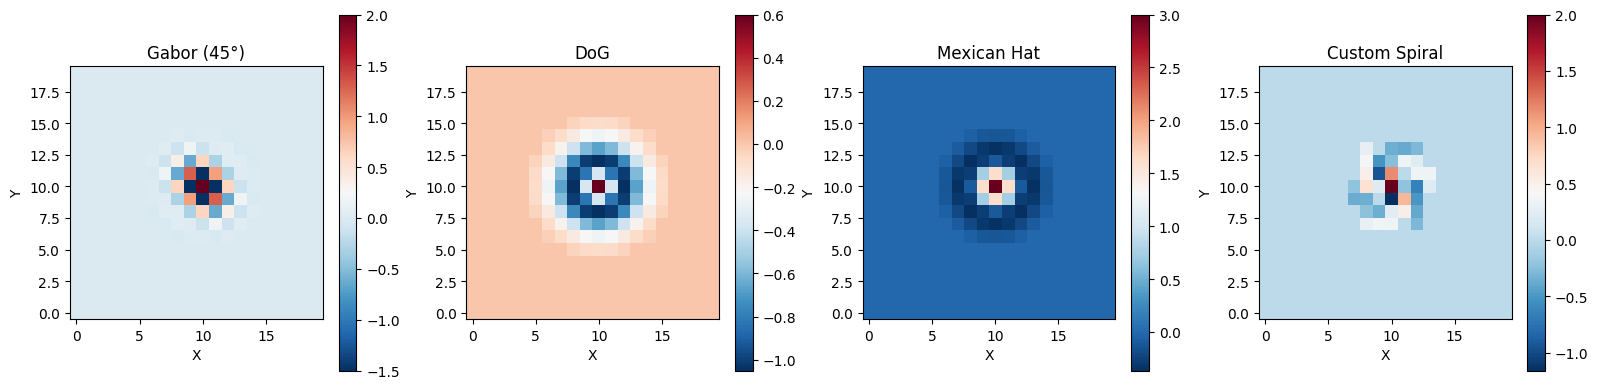

In [20]:
# Compare receptive fields
kernels = [
    (receptive_field_gabor, 'Gabor (45°)'),
    (receptive_field_dog, 'DoG'),
    (rf_mexican, 'Mexican Hat'),
    (rf_custom, 'Custom Spiral')
]

fig, axes = plt.subplots(1, 4, figsize=(16, 4))

for idx, (rf, name) in enumerate(kernels):
    im = axes[idx].imshow(rf, cmap='RdBu_r', origin='lower')
    axes[idx].set_title(name)
    axes[idx].set_xlabel('X')
    axes[idx].set_ylabel('Y')
    plt.colorbar(im, ax=axes[idx])

plt.tight_layout()
plt.show()

## 7. Combining E-I Networks with Kernel Connectivity

Real neural circuits often combine excitatory-inhibitory structure with spatial organization. Let's create a network that has both properties.

In [21]:
# Create positions for E-I network
n_combined = 400
positions_combined = np.random.uniform(0, 1000, (n_combined, 2)) * u.um

# First, establish E-I structure
ei_spatial = conn.ExcitatoryInhibitory(
    exc_ratio=0.8,
    exc_prob=0.0,  # Will use kernel instead
    inh_prob=0.0,  # Will use kernel instead
    seed=42
)

# Create separate Gaussian kernels for E and I
# E neurons have broader connectivity
gauss_e = conn.GaussianKernel(
    sigma=120 * u.um,
    max_distance=360 * u.um,
    weight=1.0 * u.nS,
    seed=42
)

# I neurons have narrower, stronger connectivity
gauss_i = conn.GaussianKernel(
    sigma=60 * u.um,
    max_distance=180 * u.um,
    weight=-1.2 * u.nS,
    seed=43
)

# Generate E connections
n_exc_combined = int(n_combined * 0.8)
result_e = gauss_e(
    pre_size=n_exc_combined,
    post_size=n_combined,
    pre_positions=positions_combined[:n_exc_combined],
    post_positions=positions_combined
)

# Generate I connections
result_i = gauss_i(
    pre_size=n_combined - n_exc_combined,
    post_size=n_combined,
    pre_positions=positions_combined[n_exc_combined:],
    post_positions=positions_combined
)

# Adjust I indices to account for E neurons
result_i_pre = result_i.pre_indices + n_exc_combined

# Combine both
combined_pre = np.concatenate([result_e.pre_indices, result_i_pre])
combined_post = np.concatenate([result_e.post_indices, result_i.post_indices])
combined_weights = np.concatenate([
    u.Quantity(result_e.weights).mantissa,
    u.Quantity(result_i.weights).mantissa
])

print(f"Combined E-I spatial network:")
print(f"  E connections: {len(result_e.pre_indices)}")
print(f"  I connections: {len(result_i.pre_indices)}")
print(f"  Total connections: {len(combined_pre)}")

Combined E-I spatial network:
  E connections: 23207
  I connections: 2593
  Total connections: 25800


### 7.1 Visualizing Combined E-I Spatial Network

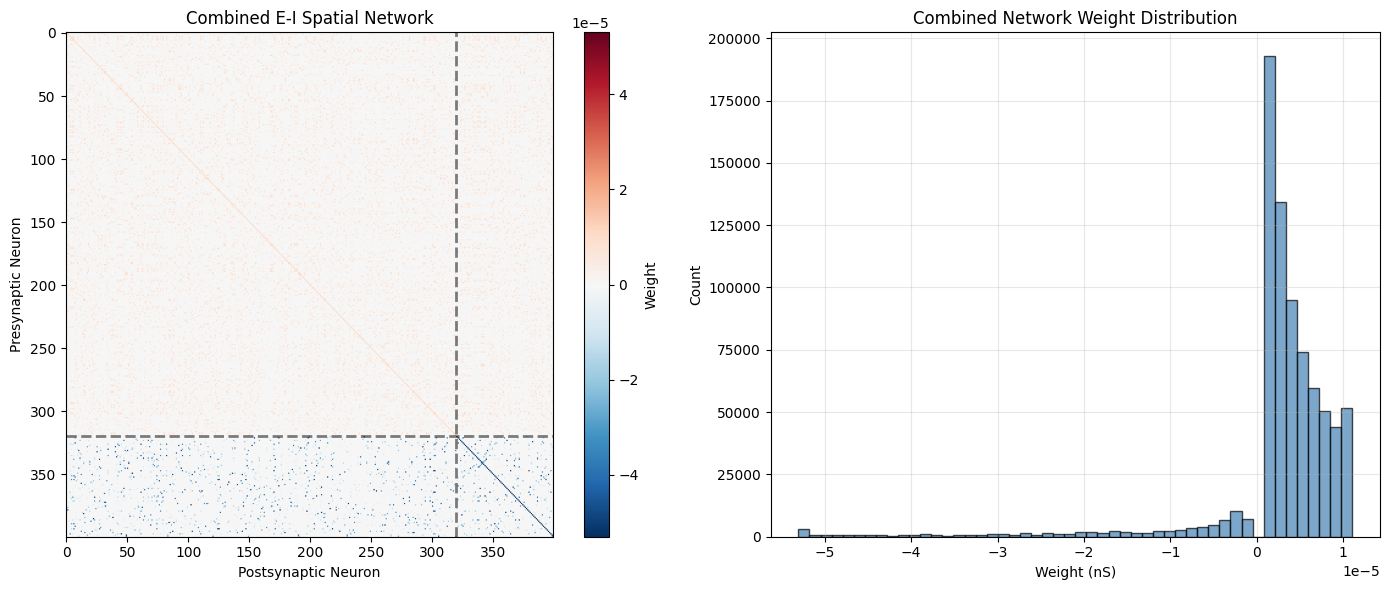

In [22]:
# Create connectivity matrix
conn_mat_combined = np.zeros((n_combined, n_combined))
conn_mat_combined[combined_pre, combined_post] = combined_weights

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Full connectivity matrix
vis.connectivity_matrix(
    conn_mat_combined,
    cmap='RdBu_r',
    center_zero=True,
    show_colorbar=True,
    ax=axes[0],
    title='Combined E-I Spatial Network',
    xlabel='Postsynaptic Neuron',
    ylabel='Presynaptic Neuron'
)

# Add separation line
axes[0].axhline(y=n_exc_combined - 0.5, color='black', linewidth=2, linestyle='--', alpha=0.5)
axes[0].axvline(x=n_exc_combined - 0.5, color='black', linewidth=2, linestyle='--', alpha=0.5)

# Weight distribution
vis.distribution_plot(
    combined_weights,
    bins=50,
    alpha=0.7,
    colors=['steelblue'],
    edgecolor='black',
    ax=axes[1],
    xlabel='Weight (nS)',
    ylabel='Count',
    title='Combined Network Weight Distribution'
)

plt.tight_layout()
plt.show()

### 7.2 Spatial Analysis of Combined Network

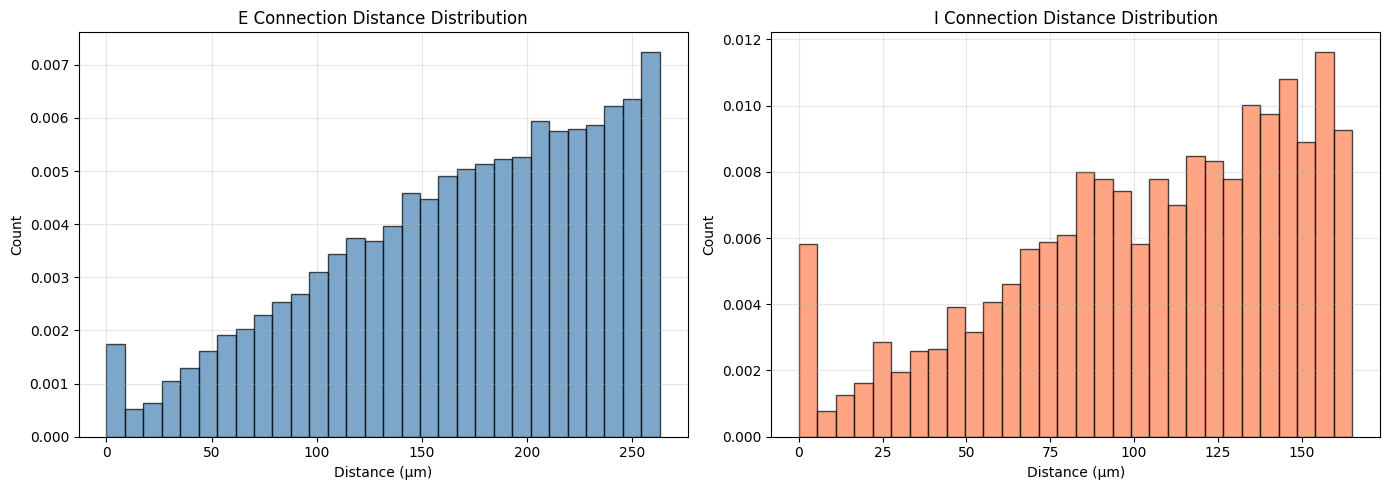

Mean E connection distance: 168.6 μm
Mean I connection distance: 104.1 μm


In [23]:
# Analyze spatial properties
# Calculate connection distances
pos_vals = u.Quantity(positions_combined).mantissa
distances = np.sqrt(np.sum((pos_vals[combined_pre] - pos_vals[combined_post]) ** 2, axis=1))

# Separate E and I distances
e_mask = combined_pre < n_exc_combined
i_mask = combined_pre >= n_exc_combined
distances_e = distances[e_mask]
distances_i = distances[i_mask]

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Distance distributions
vis.distribution_plot(
    distances_e,
    bins=30,
    alpha=0.7,
    colors=['steelblue'],
    edgecolor='black',
    ax=axes[0],
    xlabel='Distance (μm)',
    ylabel='Count',
    title='E Connection Distance Distribution'
)

vis.distribution_plot(
    distances_i,
    bins=30,
    alpha=0.7,
    colors=['coral'],
    edgecolor='black',
    ax=axes[1],
    xlabel='Distance (μm)',
    ylabel='Count',
    title='I Connection Distance Distribution'
)

plt.tight_layout()
plt.show()

print(f"Mean E connection distance: {np.mean(distances_e):.1f} μm")
print(f"Mean I connection distance: {np.mean(distances_i):.1f} μm")